# Landsat Anomaly Detection 
## [Using Novelty Detection in Keras with Generative Adversarial Network]

This notebook is used to work on anomaly detection for Landsat data sets. 

To Train the model, run this first.
```bash
python models.py
```

It is recommended to understand how the model works in general before continuing the implementation. 

→ [How to do Novelty Detection in Keras with Generative Adversarial Network (Part 1)](https://www.dlology.com/blog/how-to-do-novelty-detection-in-keras-with-generative-adversarial-network/)


In [1]:
from utils import *
from kh_tools import *
import models
import imp
imp.reload(models)
from models import ALOCC_Model
from keras.datasets import mnist

from keras.losses import binary_crossentropy
from keras import backend as K

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [97]:
self = ALOCC_Model(dataset_name='mnist', input_height=28,input_width=28)

reconstructor
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
batch_normalization_14 (Batc (None, 14, 14, 8)         32        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 8)           0      

## Choose a stopping criterion
The training procedure is stopped when R successfully maps noisy images to clean images carrying the concept of the target class.  When R can reconstruct its input with minimum error. In the following case, we pick the epoch 3.

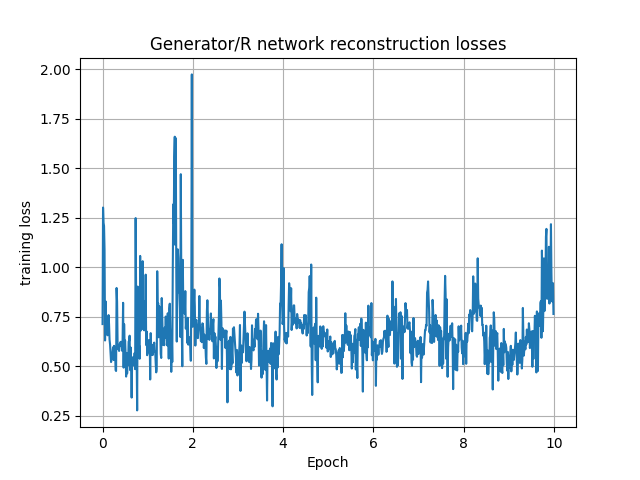

In [98]:
# This image was generated at the end of the models.py training procedure to help pick a ending epoch to load. 
from IPython.display import Image
Image(filename='plot_g_recon_losses.png') 


In [99]:
root="./checkpoint/"

#model=root+"ALOCC_Model_9.h5"

#model=root+"ALOCC_iz_28_bs_500_si_50000.h5"
#model=root+"ALOCC_iz_28_bs_250_si_10000.h5"
#model=root+"ALOCC_ep_0_iz_28_bs_20_si_500.h5"   
#model=root+"ALOCC_ep_3_iz_28_bs_250_si_10000.h5"
#model=root+"ALOCC_ep_9_iz_28_bs_500_si_9000_sig_0.155.h5"

#model=root+"ALOCC_ep_9_iz_28_bs_600_si_40000_sig_1550.h5"
#model=root+"ALOCC_ep_9_iz_28_bs_250_si_10000_sig_10000.h5"
#model=root+"ALOCC_ep_9_iz_28_bs_250_si_10000_sig_100.h5"

#model=root+"ALOCC_ep_6_iz_28_bs_500_si_25000_sig_1000.h5"
#model=root+"ALOCC_ep_9_iz_28_bs_500_si_5000_sig_1550.h5"

#model=root+"ALOCC_ep_9_iz_28_bs_500_si_10000_sig_5000.h5"
#model=root+"ALOCC_ep_9_iz_28_bs_500_si_10000_sig_100.h5"

model=root+"ALOCC_ep_4_iz_28_bs_500_si_10000_sig_1000.h5"

self.adversarial_model.load_weights(model)



In [29]:
def find_list_files(pattern_filename, path):
    '''
    Find list of files following a pattern filename within a path
    This returns a list of results, void list [] if items not found
    '''
    import os,fnmatch
    result = []
    for root, dirs, files in os.walk(path): # os walk is a generator
        for name in files:
            if fnmatch.fnmatch(name, pattern_filename):
                result.append(os.path.join(root, name))
    return result


In [30]:
import cv2
def load_image(ifile):
    image = cv2.imread(ifile)
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [57]:
## LOAD DATA FROM EXP 3/4
root = "/QCOLT/QCOLT_DEV_OPS/"

path = root +'/TDS_NOVELTY_DETECTION/EXP_03/nominal_chips/'    
#path = root +'/TDS_NOVELTY_DETECTION/EXP_04/nominal_chips/'    

# LIST CONTAINING FILENAMES WHERE DATA POINTS ARE
input_files  = [f for f in find_list_files("LS*png",path)]
input_files_cropped = []
for s in input_files:
    crop_filename = s.split('/')[-1] #.split('__')[0]
    input_files_cropped.append(crop_filename)
print("Number of input files: ",len(input_files_cropped))

# LIST CONTAINING DATA POINTS FROM EXPERIMENT
assert len(input_files) > 0

list_samples=[]
for ifile in input_files:
    list_samples.append(load_image(ifile))
    

import numpy as np
X_train = np.array(list_samples)   
#X_train = loader.load_data()

X_train = X_train / 255
print(X_train.shape)
print("Number of samples loaded =",X_train.shape[0])
print("Dimensions (H,W) = ({},{})".format(X_train.shape[1],X_train.shape[2]))

Number of input files:  45483


In [170]:
print("Loading Train Data")

#(X_train, y_train), (_, _) = mnist.load_data()
#X_train = X_train / 255

#from landsat_data_loader import LandsatDataLoader

#loader = LandsatDataLoader(path)   

#list_samples=[]
#for ifile in input_files:
#    list_samples.append(load_image(ifile))
    
#import numpy as np
#X_train = np.array(list_samples)   
#X_train = loader.load_data()
#print(X_train[0])

#X_train = X_train / 255
#print(X_train.shape)
#print("Number of samples loaded =",X_train.shape[0])
#print("Dimensions (H,W) = ({},{})".format(X_train.shape[1],X_train.shape[2]))

Loading Train Data

/QCOLT/QCOLT_DEV_OPS//TDS_NOVELTY_DETECTION/EXP_03//nominal_chips/


## Test the Reconstruction loss and Discriminator output
The `abnormal` image has a **`larger` reconstruction loss** and **`smaller` discriminator output value**.

In [60]:
import cv2

path_original_samples = root + "/Semi-Supervised_Learning/training_data/"

def gen_full_path_origin_filename(sample_filename):
    return sample_filename.split('__')[0]+".BP.PNG" 

def test_reconstruction_train(index=0, res_edge = 28):
            
    # Load data from training with index    
    data = X_train[index].reshape(-1, res_edge, res_edge, 1)[0:1]
        
    model_predicts = self.adversarial_model.predict(data)
    input_image = data[0].reshape((res_edge, res_edge))
    reconstructed_image = model_predicts[0].reshape((res_edge, res_edge))
    
    y_pred = K.variable(reconstructed_image)
    y_true = K.variable(input_image)
    error  = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    print("Index Image:",index,
          ' Reconstruction loss:', error,'Discriminator Output:', 
          model_predicts[1][0][0])
   
    montage = np.hstack((input_image,reconstructed_image))
        
    plt.title('Input Image / Reconstructed')
    plt.imshow(montage, label='Input/Recons')
    plt.show()
    
    orig_filename = input_files_cropped[index]
    coord_x = orig_filename.split('__')[1].split('_')[0].split('-')[1]
    coord_y = orig_filename.split('__')[1].split('_')[1].split('-')[1]
    
    print(" Origin image",orig_filename, " x:",coord_x, " y:",coord_y)
    ifile = gen_full_path_origin_filename(orig_filename)

    original = load_image(path_original_samples + ifile)
 
    ix = int(coord_x)
    iy = int(coord_y)
    #print_rectangle_image(original,ix,iy,28,3)
    cv2.rectangle(original,(ix,iy),(ix+28,iy+28),(255,255,255),3)

    plt.imshow(original)
    
    plt.show()

### Normal case
The network was trained with normal samples.

Index Image: 100  Reconstruction loss: 0.95140976 Discriminator Output: 0.48413187


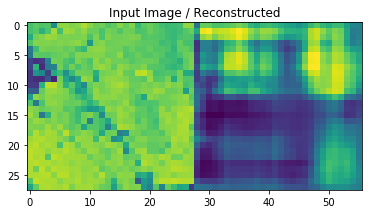

 Origin image LS04_RFUI_MSS_GTC_1P_19830108T072958_19830108T073027_002561_0173_0029_58E6__x-200_y-400_ratio-1_rows-992_cols-1024.png  x: 200  y: 400


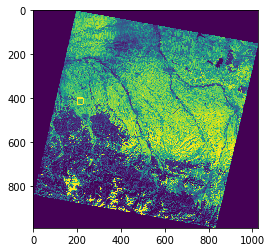

Index Image: 200  Reconstruction loss: 0.47001505 Discriminator Output: 0.88713175


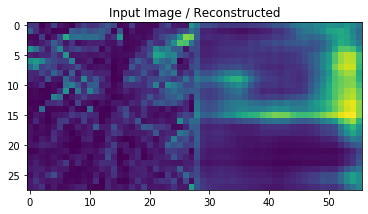

 Origin image LS04_RFUI_MSS_GTC_1P_19830108T072958_19830108T073027_002561_0173_0029_58E6__x-100_y-700_ratio-1_rows-992_cols-1024.png  x: 100  y: 700


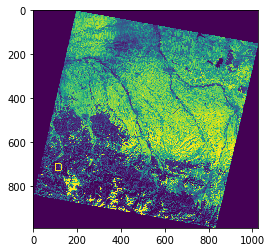

Index Image: 300  Reconstruction loss: 0.8427323 Discriminator Output: 0.07227153


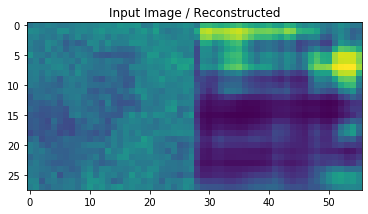

 Origin image LS05_RMPS_MSS_GTC_1P_19840901T104032_19840901T104102_002679_0203_0039_43BC__x-750_y-150_ratio-1_rows-1019_cols-1024.png  x: 750  y: 150


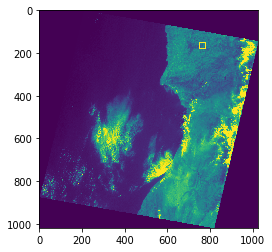

Index Image: 400  Reconstruction loss: 0.93403035 Discriminator Output: 0.14443453


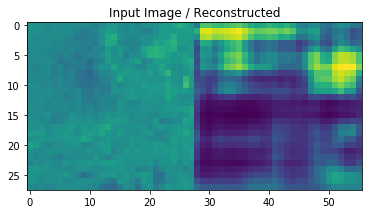

 Origin image LS05_RMPS_MSS_GTC_1P_19840901T104032_19840901T104102_002679_0203_0039_43BC__x-800_y-450_ratio-1_rows-1019_cols-1024.png  x: 800  y: 450


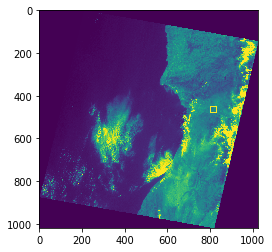

Index Image: 500  Reconstruction loss: 0.91967624 Discriminator Output: 0.16522323


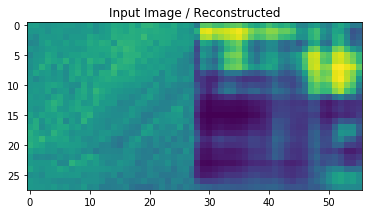

 Origin image LS05_RMPS_MSS_GTC_1P_19840901T104032_19840901T104102_002679_0203_0039_43BC__x-800_y-750_ratio-1_rows-1019_cols-1024.png  x: 800  y: 750


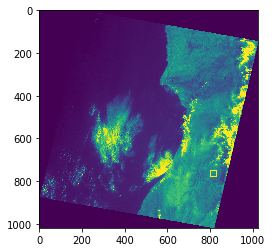

Index Image: 600  Reconstruction loss: 0.7160329 Discriminator Output: 0.7058679


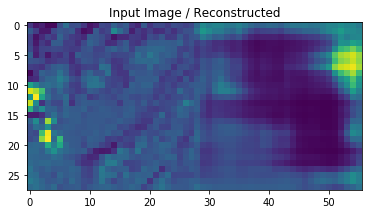

 Origin image LS05_RFUI_MSS_GTC_1P_19861019T074715_19861019T074745_014007_0177_0034_4D65__x-300_y-250_ratio-1_rows-1019_cols-1024.png  x: 300  y: 250


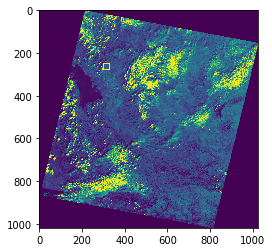

Index Image: 700  Reconstruction loss: 0.5777822 Discriminator Output: 0.92772293


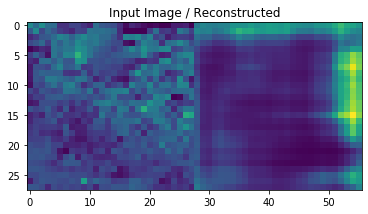

 Origin image LS05_RFUI_MSS_GTC_1P_19861019T074715_19861019T074745_014007_0177_0034_4D65__x-300_y-550_ratio-1_rows-1019_cols-1024.png  x: 300  y: 550


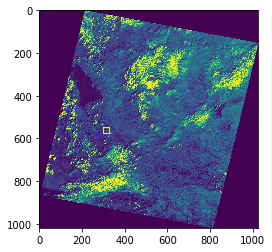

Index Image: 800  Reconstruction loss: 0.5581347 Discriminator Output: 0.69079065


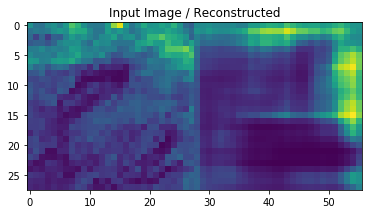

 Origin image LS05_RFUI_MSS_GTC_1P_19861019T074715_19861019T074745_014007_0177_0034_4D65__x-450_y-850_ratio-1_rows-1019_cols-1024.png  x: 450  y: 850


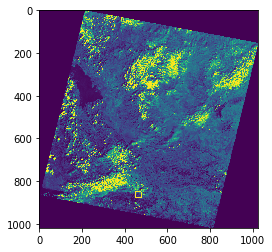

Index Image: 900  Reconstruction loss: 0.46003968 Discriminator Output: 0.70939285


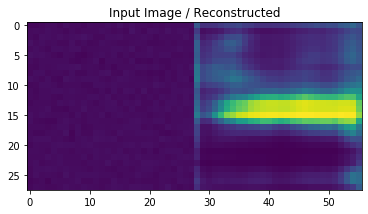

 Origin image LS03_RFUI_MSS_GTC_1P_19780805T081713_19780805T081742_002132_0195_0038_5376__x-950_y-300_ratio-1_rows-970_cols-1024.png  x: 950  y: 300


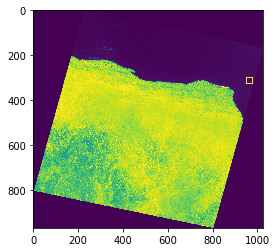

In [100]:
# SHOW RECONSTRUCTION IMAGES AND ORIGINAL TRAINING DATESET (nominal)

# choose a selection from differnt products
step = 100
for i in [step*i for i in range(1,10)]:
    test_reconstruction_train(i)
    
    


In [19]:

# Get map from product to index chip
def get_map_names_to_indices(list_samples):
    list_samples = [x.split('__')[0] for x in list_samples]

    map_product_to_indeces={}

    for index,item in enumerate(list_samples):
        if item in map_product_to_indeces:        
            map_product_to_indeces[item].append(index)
        else:
            map_product_to_indeces[item] = [index]
            
    return map_product_to_indeces

map_products_to_indeces = get_map_names_to_indices(input_files_cropped)

In [232]:
#for k,v in map_products_to_indeces.items():
#    print(k," len:",len(v)," min:",min(v)," max:",max(v))
    
    

In [20]:
# This function predicts with the model loss error and discriminator output

# WARNING: This uses X_train
def get_loss_discriminator(index=0, res_edge = 28):       
    data = X_train[index].reshape(-1, res_edge, res_edge, 1)[0:1]
        
    model_predicts = self.adversarial_model.predict(data)
    input_image = data[0].reshape((res_edge, res_edge))
    reconstructed_image = model_predicts[0].reshape((res_edge, res_edge))
    
    y_pred = K.variable(reconstructed_image)
    y_true = K.variable(input_image)
    error  = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    discriminator_out = model_predicts[1][0][0]
    #print("Index Image:",index,
    ##      ' Reconstruction loss:', error,'Discriminator Output:', 
    #      discriminator_out)
   
    return error, discriminator_out

   

In [101]:
# CALCULATE FINGER-PRINT OF MEASUREMENTS BY PRODUCT

# TESTING DATA POINTS COMING FROM THE SAME PRODUCT
key = 'LS04_RFUI_MSS_GTC_1P_19830108T072958_19830108T073027_002561_0173_0029_58E6'
indices =  map_products_to_indeces[key]

list_losses = []
list_discri = []
for i in indices:
    loss,disc = get_loss_discriminator(index=i)
    print("calculating index ",i," loss:",loss," disc:",disc)
    list_losses.append(loss)
    list_discri.append(disc)
    


calculating index  0  loss: 1.0049663  disc: 0.48135674
calculating index  1  loss: 0.99329525  disc: 0.42267886
calculating index  2  loss: 1.0478005  disc: 0.39173472
calculating index  3  loss: 0.8146477  disc: 0.44845667
calculating index  4  loss: 0.79866594  disc: 0.2290494
calculating index  5  loss: 0.94273174  disc: 0.40231186
calculating index  6  loss: 0.9972232  disc: 0.44679442
calculating index  7  loss: 1.0255355  disc: 0.35552338
calculating index  8  loss: 0.96717864  disc: 0.31547302
calculating index  9  loss: 0.7363683  disc: 0.41335747
calculating index  10  loss: 0.7976933  disc: 0.3727832
calculating index  11  loss: 0.8188084  disc: 0.29536268
calculating index  12  loss: 0.66337097  disc: 0.72365975
calculating index  13  loss: 0.80669063  disc: 0.45353475
calculating index  14  loss: 0.8241559  disc: 0.39576986
calculating index  15  loss: 0.85931116  disc: 0.13571838
calculating index  16  loss: 0.95029384  disc: 0.4631876
calculating index  17  loss: 0.90256

calculating index  144  loss: 0.9877799  disc: 0.45401528
calculating index  145  loss: 0.9941599  disc: 0.3769005
calculating index  146  loss: 1.0183405  disc: 0.4312415
calculating index  147  loss: 1.0502161  disc: 0.45511773
calculating index  148  loss: 0.9347438  disc: 0.24884203
calculating index  149  loss: 0.63293284  disc: 0.81705064
calculating index  150  loss: 0.5623691  disc: 0.96526927
calculating index  151  loss: 0.67244965  disc: 0.74908864
calculating index  152  loss: 0.8345588  disc: 0.60361755
calculating index  153  loss: 0.5039124  disc: 0.9486168
calculating index  154  loss: 0.44296604  disc: 0.9812789
calculating index  155  loss: 0.69156075  disc: 0.93363243
calculating index  156  loss: 0.9285677  disc: 0.36904094
calculating index  157  loss: 0.9063362  disc: 0.22433344
calculating index  158  loss: 0.9757398  disc: 0.40879184
calculating index  159  loss: 1.0153086  disc: 0.4256749
calculating index  160  loss: 0.9723459  disc: 0.40276268
calculating ind

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def get_histogram_from_list(minr, maxr,
                            step, values,
                            titleX,titleY,title):
    ''''
    This functions calculates a histogram based on parameters
    minr: Minimum range on input values
    maxr: Maximum range on input values
    step: 
    values: list of values
    titleX: label on X
    titleY: label on Y
    '''
    
    bins = np.arange(minr,maxr,step)

    plt.hist(values, bins=bins, alpha=0.5)
    plt.title(title)
    plt.xlabel(titleX)
    plt.ylabel(titleY)

    return plt


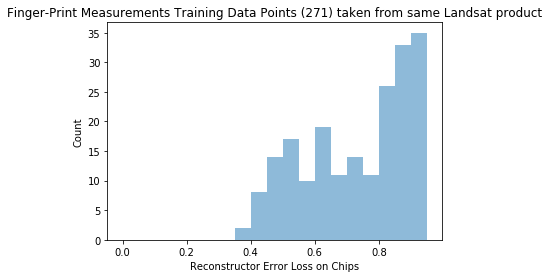

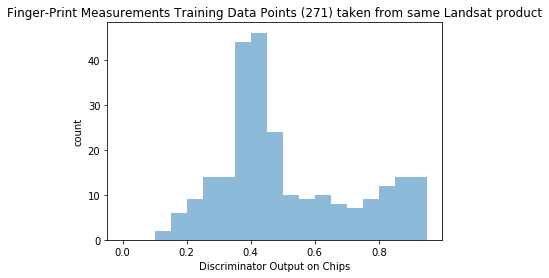

In [102]:
#CASE BATCH NORMALIZATION

title = "Finger-Print Measurements Training Data Points ({}) taken from same Landsat product".format(len(list_losses))

llosses = list_losses
histo = get_histogram_from_list(0,1,0.05,llosses,"Reconstructor Error Loss on Chips","Count",title)
histo.show()

ddiscri = list_discri
histo = get_histogram_from_list(0,1,0.05,ddiscri,"Discriminator Output on Chips","count",title)
histo.show()

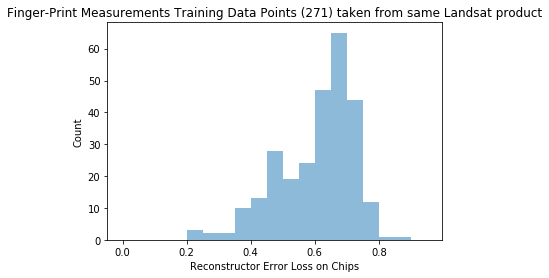

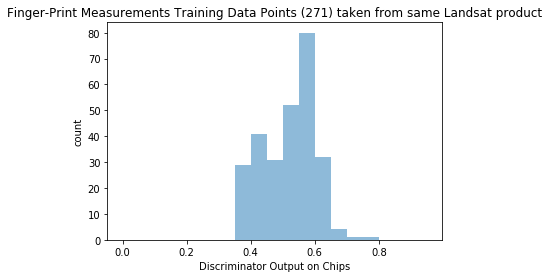

In [73]:
title = "Finger-Print Measurements Training Data Points ({}) taken from same Landsat product".format(len(list_losses))

llosses = list_losses
histo = get_histogram_from_list(0,1,0.05,llosses,"Reconstructor Error Loss on Chips","Count",title)
histo.show()

ddiscri = list_discri
histo = get_histogram_from_list(0,1,0.05,ddiscri,"Discriminator Output on Chips","count",title)
histo.show()

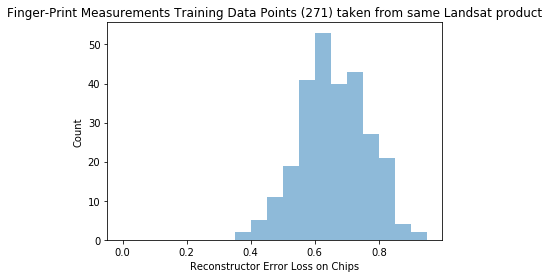

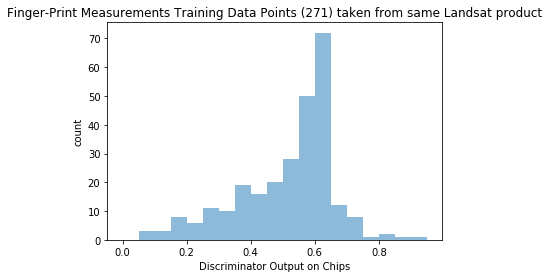

In [264]:
title = "Finger-Print Measurements Training Data Points ({}) taken from same Landsat product".format(len(list_losses))

llosses = list_losses
histo = get_histogram_from_list(0,1,0.05,llosses,"Reconstructor Error Loss on Chips","Count",title)
histo.show()

ddiscri = list_discri
histo = get_histogram_from_list(0,1,0.05,ddiscri,"Discriminator Output on Chips","count",title)
histo.show()

## Abnormal cases
The network was not trained on those labels, so the Generator/R network find it hard to reconstruct the input images reflected in higher reconstruction loss values.

Discriminator also outputs a lower value compared to normal ones.

In [82]:
root = "/QCOLT/QCOLT_DEV_OPS/"
test_path = root +'/Semi-Supervised_Learning/test_data/anomalous_chips/'    

# LIST CONTAINING FILENAMES WHERE DATA POINTS ARE

input_files  = [f for f in find_list_files("LS*png",test_path)]


In [78]:
from landsat_data_loader import LandsatDataLoader    
loader = LandsatDataLoader(test_path)   
X_test = loader.load_data()
X_test = X_test / 255
#print(X_train.shape)
print("Number of samples loaded =",X_test.shape[0])
print("Dimensions (H,W) = ({},{})".format(X_test.shape[1],X_test.shape[2]))

Number of input files loaded: 252
Number of samples loaded = 252
Dimensions (H,W) = (28,28)


In [79]:
def test_reconstruction_test(index=0, res_edge = 28):
    data = X_test[index].reshape(-1, res_edge, res_edge, 1)[0:1]
        
    model_predicts = self.adversarial_model.predict(data)
    input_image = data[0].reshape((res_edge, res_edge))
    reconstructed_image = model_predicts[0].reshape((res_edge, res_edge))
    
    y_pred = K.variable(reconstructed_image)
    y_true = K.variable(input_image)
    error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    discrim = model_predicts[1][0][0]
    print("Index Image:",index,
          ' Reconstruction loss:',error,
          ' Discriminator Output:',discrim)
    
    #print("Model Predicts:",model_predicts)
    montage = np.hstack((input_image,reconstructed_image))
        
    plt.title('Input Image / Reconstructed')
    plt.imshow(montage, label='Input/Recons')
    #fig.add_subplot(rows, columns, 2)
    #plt.title('Reconstruction')
    #plt.imshow(reconstructed_image, label='Reconstructed')
    plt.show()

Index Image: 0  Reconstruction loss: 0.7224136  Discriminator Output: 0.9629615


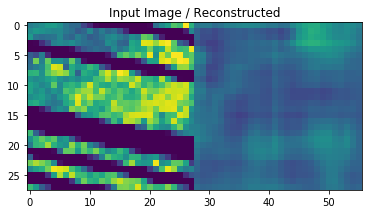

Index Image: 4  Reconstruction loss: 0.8278039  Discriminator Output: 0.6993626


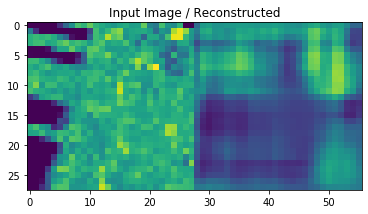

Index Image: 8  Reconstruction loss: 0.44396827  Discriminator Output: 0.9949608


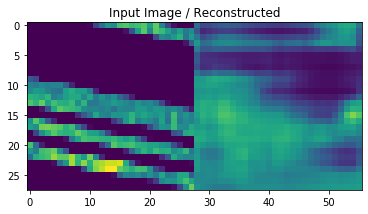

Index Image: 12  Reconstruction loss: 0.83306414  Discriminator Output: 0.3228665


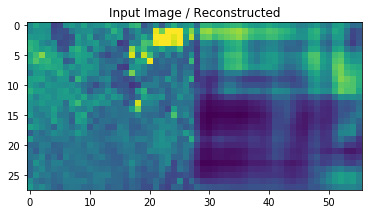

Index Image: 16  Reconstruction loss: 0.63865036  Discriminator Output: 0.96789145


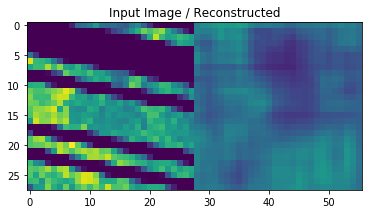

Index Image: 20  Reconstruction loss: 0.45588353  Discriminator Output: 0.95723015


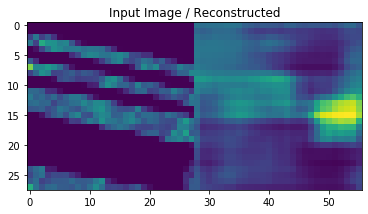

Index Image: 24  Reconstruction loss: 0.85667866  Discriminator Output: 0.155336


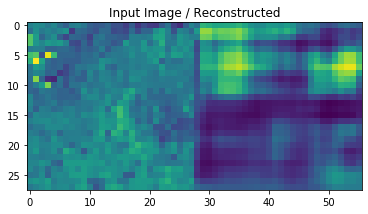

Index Image: 28  Reconstruction loss: 0.85604054  Discriminator Output: 0.47485855


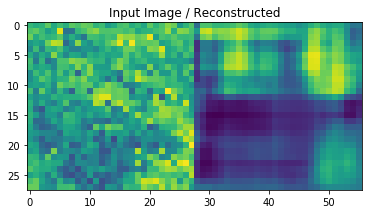

Index Image: 32  Reconstruction loss: 0.51845896  Discriminator Output: 0.9308401


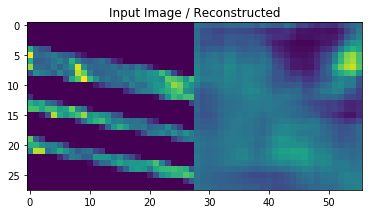

Index Image: 36  Reconstruction loss: 0.6683087  Discriminator Output: 0.86565536


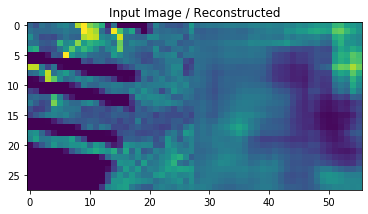

Index Image: 40  Reconstruction loss: 0.8030386  Discriminator Output: 0.16259277


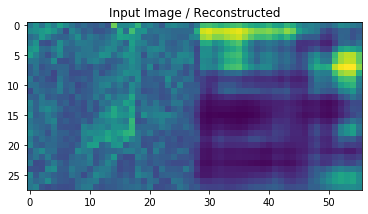

Index Image: 44  Reconstruction loss: 0.7722917  Discriminator Output: 0.40780118


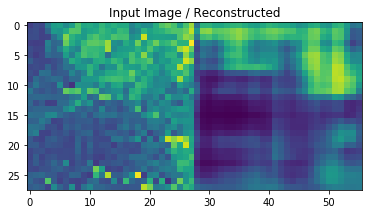

Index Image: 48  Reconstruction loss: 0.6636472  Discriminator Output: 0.9658707


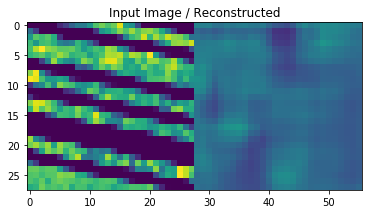

Index Image: 52  Reconstruction loss: 0.5037995  Discriminator Output: 0.99519324


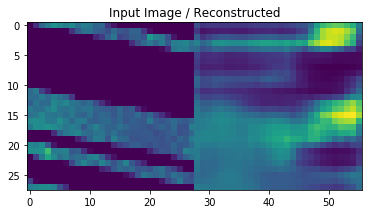

Index Image: 56  Reconstruction loss: 0.7855142  Discriminator Output: 0.16326398


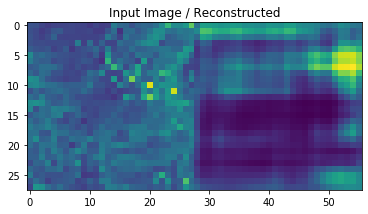

In [103]:
step=4
for i in [step*i for i in range(0,15)]:
    test_reconstruction_test(i)
  
    

In [45]:
def get_loss_disc_on_test(index=0, res_edge = 28):
    data = X_test[index].reshape(-1, res_edge, res_edge, 1)[0:1]
        
    model_predicts = self.adversarial_model.predict(data)
    input_image = data[0].reshape((res_edge, res_edge))
    reconstructed_image = model_predicts[0].reshape((res_edge, res_edge))
    
    y_pred = K.variable(reconstructed_image)
    y_true = K.variable(input_image)
    error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    discrim = model_predicts[1][0][0]

    return error, discrim
    

In [104]:
test_list_losses=[]
test_list_discri=[]

total_img = len(X_test)

print(total_img)
for index in range(0,total_img):
    loss, discrim = get_loss_disc_on_test(index=index)
    test_list_losses.append(loss)
    test_list_discri.append(discrim)
    print("calculating index ",index," loss:",loss," discrim:",discrim)
   

252
calculating index  0  loss: 0.7224136  discrim: 0.9629615
calculating index  1  loss: 0.6456931  discrim: 0.9771947
calculating index  2  loss: 0.54125607  discrim: 0.9906465
calculating index  3  loss: 0.59372044  discrim: 0.6789404
calculating index  4  loss: 0.8278039  discrim: 0.6993626
calculating index  5  loss: 0.5768216  discrim: 0.93856555
calculating index  6  loss: 0.5629551  discrim: 0.8782496
calculating index  7  loss: 0.5721664  discrim: 0.914243
calculating index  8  loss: 0.44396827  discrim: 0.9949608
calculating index  9  loss: 0.5094465  discrim: 0.80544573
calculating index  10  loss: 0.8231533  discrim: 0.5018911
calculating index  11  loss: 0.9223851  discrim: 0.21834393
calculating index  12  loss: 0.83306414  discrim: 0.3228665
calculating index  13  loss: 0.9098721  discrim: 0.28854066
calculating index  14  loss: 0.9375891  discrim: 0.32016084
calculating index  15  loss: 0.9492789  discrim: 0.42406148
calculating index  16  loss: 0.63865036  discrim: 0.9

calculating index  137  loss: 0.9418146  discrim: 0.33270523
calculating index  138  loss: 0.92105854  discrim: 0.31831074
calculating index  139  loss: 0.95494497  discrim: 0.4294272
calculating index  140  loss: 0.76252717  discrim: 0.2745458
calculating index  141  loss: 0.8508631  discrim: 0.29496688
calculating index  142  loss: 0.9290121  discrim: 0.4378389
calculating index  143  loss: 0.92364013  discrim: 0.45974305
calculating index  144  loss: 0.9132288  discrim: 0.2883657
calculating index  145  loss: 0.8744225  discrim: 0.36017317
calculating index  146  loss: 0.85982114  discrim: 0.22194861
calculating index  147  loss: 0.8957025  discrim: 0.22570021
calculating index  148  loss: 0.6254894  discrim: 0.9272648
calculating index  149  loss: 0.44383377  discrim: 0.9943493
calculating index  150  loss: 0.52312386  discrim: 0.9860746
calculating index  151  loss: 0.57981837  discrim: 0.9400532
calculating index  152  loss: 0.51589304  discrim: 0.99662775
calculating index  153 

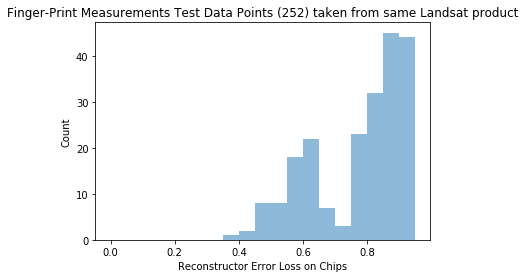

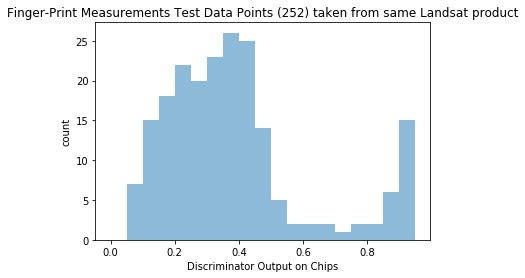

In [105]:
# BATCH NORMALISATION

title = "Finger-Print Measurements Test Data Points ({}) taken from same Landsat product".format(len(test_list_losses))

llosses = test_list_losses

histo = get_histogram_from_list(0,1,0.05,llosses,"Reconstructor Error Loss on Chips","Count",title)
histo.show()

ddiscri = test_list_discri
histo = get_histogram_from_list(0,1,0.05,ddiscri,"Discriminator Output on Chips","count",title)
histo.show()

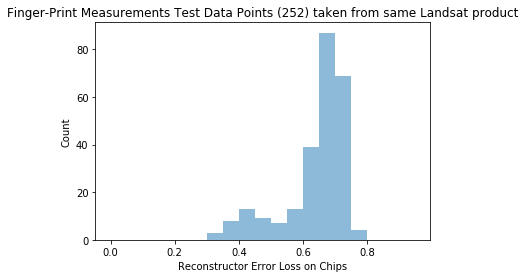

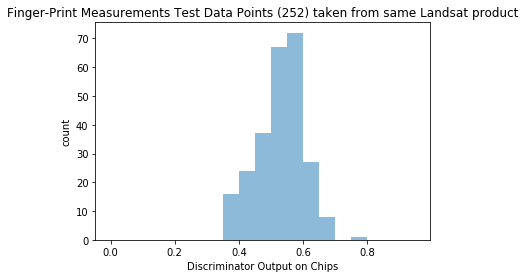

In [83]:
title = "Finger-Print Measurements Test Data Points ({}) taken from same Landsat product".format(len(test_list_losses))

llosses = test_list_losses

histo = get_histogram_from_list(0,1,0.05,llosses,"Reconstructor Error Loss on Chips","Count",title)
histo.show()

ddiscri = test_list_discri
histo = get_histogram_from_list(0,1,0.05,ddiscri,"Discriminator Output on Chips","count",title)
histo.show()

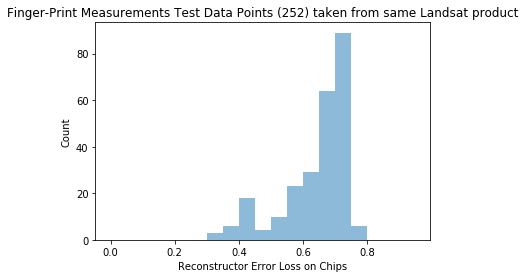

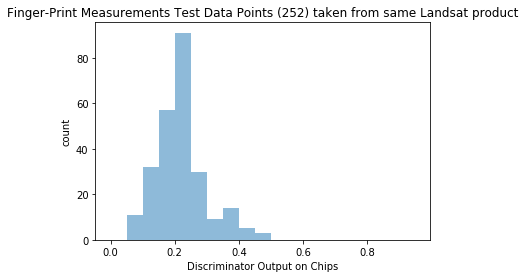

In [263]:
title = "Finger-Print Measurements Test Data Points ({}) taken from same Landsat product".format(len(test_list_losses))

llosses = test_list_losses

histo = get_histogram_from_list(0,1,0.05,llosses,"Reconstructor Error Loss on Chips","Count",title)
histo.show()

ddiscri = test_list_discri
histo = get_histogram_from_list(0,1,0.05,ddiscri,"Discriminator Output on Chips","count",title)
histo.show()
